In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace videos/run/daria_run.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: videos/run/daria_run.avi  
replace videos/run/ido_run.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: videos/run/ido_run.avi  
  inflating: videos/run/lena_run1.avi  
  inflating: videos/run/denis_run.avi  
  inflating: videos/run/eli_run.avi  
  inflating: videos/run/moshe_run.avi  
  inflating: videos/run/lena_run2.avi  
  inflating: videos/run/lyova_run.avi  
  inflating: videos/run/ira_run.avi  
  inflating: videos/run/shahar_run.avi  
  inflating: videos/wave1/ira_wave1.avi  
  inflating: videos/wave1/ido_wave1.avi  
  inflating: videos/wave1/lena_wave1.avi  
  inflating: videos/wave1/lyova_wave1.avi  
  inflating: videos/wave1/moshe_wave1.avi  
  inflating: videos/wave1/eli_wave1.avi  
  inflating: videos/wave1/denis_wave1.avi  
  inflating: videos/wave1/shahar_wave1.avi  
  inflating: videos/wave1/daria_wave1.avi  
  inflating: videos/jump/ira_jump.avi  
  infla

In [ ]:
!pip install av
from torchvision.io import read_video, write_video

# we select one of the video arbitrarily
video_avi, _, fps = read_video('videos/walk/daria_walk.avi', pts_unit='sec')

# note the shape of the output tensor
print(video_avi.shape)

torch.Size([84, 144, 180, 3])


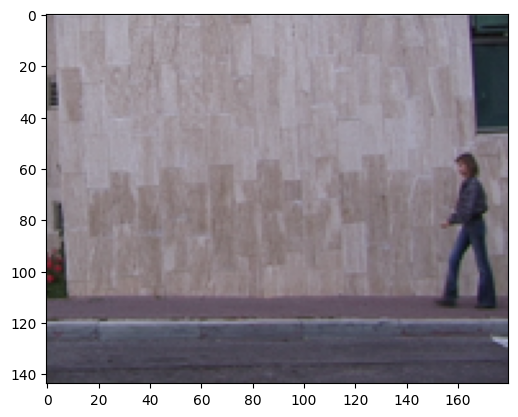

In [ ]:
import matplotlib.pyplot as plt

# let's display the first image
plt.imshow(video_avi[0,...])

In [ ]:
frame = video_avi[0]  # Get the first frame
if len(frame.shape) == 4:  # If it includes multiple frames
    frame = frame[0]  # Take only the first frame
print(f"Corrected Frame Shape: {frame.shape}")

Corrected Frame Shape: torch.Size([144, 180, 3])


In [ ]:
git clone https://github.com/Cadene/pretrained-models.pytorch.git
pip install -r requirements.txt

import pretrainedmodels

model_name = 'resnet50'  # Specify the model name
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

In [ ]:
import numpy as np


if not isinstance(frame, np.ndarray):
    frame = np.array(frame)

In [ ]:
import cv2

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


In [ ]:
print(f"Dataset Shape: {video_avi.shape}")
if frame.shape[-1] > 3:
    frame = frame[:, :, :3]  # Keep only the first 3 channels (RGB)

print(f"Fixed Frame Shape: {frame.shape}")

Dataset Shape: torch.Size([84, 144, 180, 3])
Fixed Frame Shape: (144, 180, 3)


In [ ]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Ensure frame is converted to a NumPy array
frame_np = np.array(frame).astype(np.uint8)  # Ensure correct dtype

# Convert NumPy array to PIL Image
frame_pil = Image.fromarray(frame_np)

# Define transformation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.8),  # Flip 80% of the time
    transforms.RandomRotation(20),  # Rotate frames randomly
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Adjust brightness & color
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Apply random transformations
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # Crop with variable sizes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Apply transformations to the PIL image
processed_frame = transform(frame_pil)

print(f"Processed Frame Shape: {processed_frame.shape}")  # Expected: (3, 224, 224)




Processed Frame Shape: torch.Size([3, 224, 224])


In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import cv2
import os
from PIL import Image  # Import PIL for conversion

class VideoDataset(Dataset):
    def __init__(self, video_paths, sequence_length=16, transform=None):
        self.video_paths = video_paths
        self.sequence_length = sequence_length
        self.transform = transform

    def extract_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < self.sequence_length:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            frame_pil = Image.fromarray(frame)  # Convert NumPy to PIL

            if self.transform:
                frame_pil = self.transform(frame_pil)  # Apply transformations

            frames.append(frame_pil)

        cap.release()

        # Ensure we have the correct sequence length (pad if needed)
        if len(frames) < self.sequence_length:
            frames.extend([frames[-1]] * (self.sequence_length - len(frames)))  # Duplicate last frame

        return torch.stack(frames)  # Shape: (sequence_length, C, H, W)


    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = self.extract_frames(video_path)
        label = torch.tensor(idx % 2)  # Dummy labels, replace with actual labels
        return frames, label

# Get list of video paths
video_folder = "videos/walk/"
video_paths = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.avi')]

# Create dataset and dataloader
video_dataset = VideoDataset(video_paths, transform=transform)
video_loader = DataLoader(video_dataset, batch_size=4, shuffle=True)

# Test the dataloader
sample_frames, sample_label = next(iter(video_loader))
print(f"Batch Shape: {sample_frames.shape}")  # Expected: (batch_size, sequence_length, C, H, W)


Batch Shape: torch.Size([4, 16, 3, 224, 224])


In [ ]:
print(f"Total videos in dataset: {len(video_dataset)}")


Total videos in dataset: 10


Start of CNN

In [ ]:
import torchvision.models as models

class CNNFeatureExtractor(nn.Module):
    def __init__(self, backbone='resnet34'):  # Allow model selection
        super(CNNFeatureExtractor, self).__init__()

        if backbone == 'resnet50':
            resnet = models.resnet50(pretrained=True)
            self.feature_dim = 2048  # ResNet-50 outputs 2048 features
        else:
            resnet = models.resnet34(pretrained=True)  # Default: ResNet-34
            self.feature_dim = 512  # ResNet-34 outputs 512 features

        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to 1x1

    def forward(self, x):
        batch_size, sequence_length, C, H, W = x.shape
        x = x.view(batch_size * sequence_length, C, H, W)
        features = self.feature_extractor(x)
        features = self.avgpool(features)
        features = features.view(batch_size, sequence_length, -1)
        return features  # Shape: (batch, seq_len, feature_dim)

In [ ]:
class VideoClassificationModel(nn.Module):
    def __init__(self, backbone='resnet34', hidden_dim=256, num_classes=2):
        super(VideoClassificationModel, self).__init__()

        self.cnn = CNNFeatureExtractor(backbone=backbone)  # Initialize CNN
        self.lstm = nn.LSTM(input_size=self.cnn.feature_dim,  # Auto-detect feature size
                            hidden_size=hidden_dim, num_layers=2,
                            batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        features = self.cnn(x)
        lstm_out, _ = self.lstm(features)
        out = self.fc(lstm_out[:, -1, :])  # Use last time step output
        return out

In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Extract all labels from dataset
all_labels = [label for _, label in video_dataset]  # Extract labels

# Compute class weights
num_samples = len(all_labels)
class_counts = np.bincount(all_labels)  # Count number of occurrences per class
class_weights = 1.0 / class_counts  # Inverse frequency to balance classes

# Assign weights to each sample
sample_weights = [class_weights[label] for label in all_labels]

# Create a weighted sampler
sampler = WeightedRandomSampler(sample_weights, num_samples, replacement=True)

# Create DataLoader with weighted sampling
video_loader = DataLoader(video_dataset, batch_size=4, sampler=sampler)

In [ ]:
from collections import Counter

# Get all labels in dataset
all_labels = [label.item() for _, label in video_dataset]

# Count occurrences of each class
label_counts = Counter(all_labels)
print("Dataset Class Distribution:", label_counts)

Dataset Class Distribution: Counter({0: 5, 1: 5})


Model Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoClassificationModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct, total = 0, 0

        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(videos)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add this line
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

# Define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True)  # 5-Fold Cross Validation

for fold, (train_index, val_index) in enumerate(kf.split(video_dataset)):
  print(f"Fold {fold+1}")

  # Create data samplers for train and validation sets
train_subsampler = SubsetRandomSampler(train_index)
val_subsampler = SubsetRandomSampler(val_index)

  # Create DataLoaders for this fold
train_loader = DataLoader(video_dataset, batch_size=4, sampler=train_subsampler)
val_loader = DataLoader(video_dataset, batch_size=4, sampler=val_subsampler)

  # Train on this fold
train(model, train_loader, criterion, optimizer, epochs=20)


def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {correct / total:.4f}")
evaluate(model, val_loader)



Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


RuntimeError: input.size(-1) must be equal to input_size. Expected 2048, got 512